In [1]:
import sys
import os
import numpy as np
import random
# Go one level up to the 'main' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add this directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:

from scipy.optimize import brentq

from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

from gqw_ansatz import GQWAnsatz



In [3]:

def calc_gamma(t, T, lambda_vec: list | np.ndarray):
    l1, l2, l3, l4, l5, l6 = lambda_vec
    s = t/T

    def _x_tau_minus_s(tau):
        x_tau = 3* l1 *((1- tau)**2) * tau \
              + 3 *l3*(1- tau) * (tau**2) \
                  + tau**3 
        return (x_tau - s)
    
    if s <= 0.0:
        tau = 0.0
    elif s >= 1.0:
        tau = 1.0
    else:
        try:
            tau = brentq(_x_tau_minus_s, 0.0, 1.0)
        except ValueError:
            tau = s
    
    y_tau = ((1 - tau)**3) + \
        (3 * l2 *   ((1- tau)**2) * tau) + \
            (3 * l4 * (1 - tau) * (tau**2)) 

    start_gamma = 10 ** (2.0 * l5)
    end_gamma = 10 ** (-3.0 * l6)
    # print(start_gamma, end_gamma)
    gamma = y_tau * start_gamma + (1 - y_tau) * end_gamma

    return gamma

In [4]:
reps = 5
T = 3.24
# delta_t = (10 ** (-5) )* ( T /reps)
delta_t =  ( T /reps)
lambda_vec = [round(random.uniform(0, 1), 3) for i in range(4)] + [round(random.random(), 3) for _ in range(2)]

# lambda_vec = [0.61029775, 0.3802406,  0.25411683, 0.90518724, 1.99407253, 0.19070556]

hopping_rate = [calc_gamma(i*delta_t, T, lambda_vec) for i in range(reps)]
print(hopping_rate)

# cost_operator = SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
#               coeffs=[3.02098758+0.j, 3.07855803+0.j, 3.26645289+0.j, 2.51501527+0.j,
#  1.51608983+0.j, 1.51000473+0.j, 1.51355398+0.j, 1.51004459+0.j,
#  1.51540905+0.j, 1.51057796+0.j])

cost_operator1 = SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ 0.20938976+0.j,  0.02219508+0.j, -0.62165403+0.j, -0.52183167+0.j,
 -0.16630805+0.j, -0.07081034+0.j,  2.34314136+0.j,  2.3438048 +0.j,
  2.34643442+0.j,  2.34496855+0.j,  2.34526134+0.j,  2.34737378+0.j,
  2.34400334+0.j,  2.3447599 +0.j,  2.34757129+0.j,  2.3492991 +0.j,
  2.34974653+0.j,  2.35313552+0.j,  2.35907177+0.j,  2.34988862+0.j,
  2.35288293+0.j])

evolution = LieTrotter()
# evolution = None
ansatz = GQWAnsatz(cost_operator1, hopping_rate=hopping_rate, reps = reps, time = T, flatten= False, evolution= evolution)


# not clear whether to multiply with delta_t again
h_parameters = [
 delta_t * calc_gamma( i * delta_t, T, lambda_vec) for i in range (reps)
] + [delta_t for _ in range(reps)]

# h_parameters = [1, 2, 3, 4, 5, 6]
ansatz.num_parameters
# ansatz.assign_parameters(h_parameters, inplace= True)
print(h_parameters)


[92.89663867799364, 90.28606436013445, 82.13382629647487, 42.93444643538906, 7.845193677487952]
[60.19702186333988, 58.50536970536712, 53.22271944011572, 27.821521290132115, 5.083685503012193, 0.648, 0.648, 0.648, 0.648, 0.648]


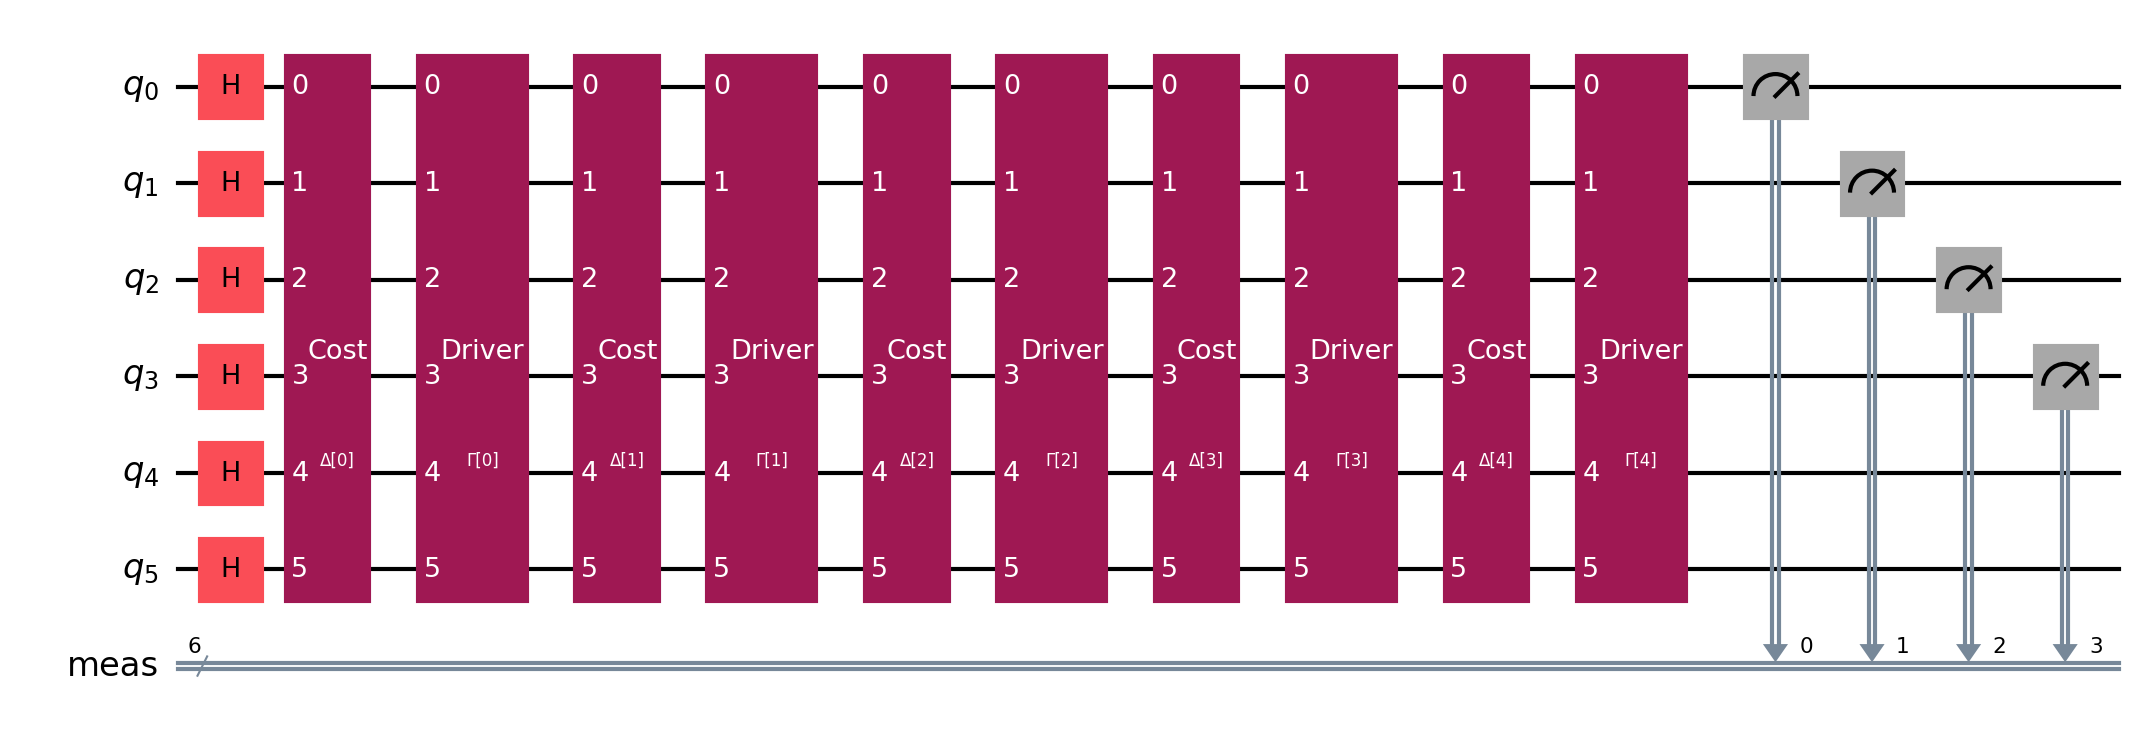

In [6]:
ansatz.measure(range(4), range(4))
ansatz.decompose().draw('mpl', 1.5)

In [14]:

ansatz.measure(range(4), range(4))


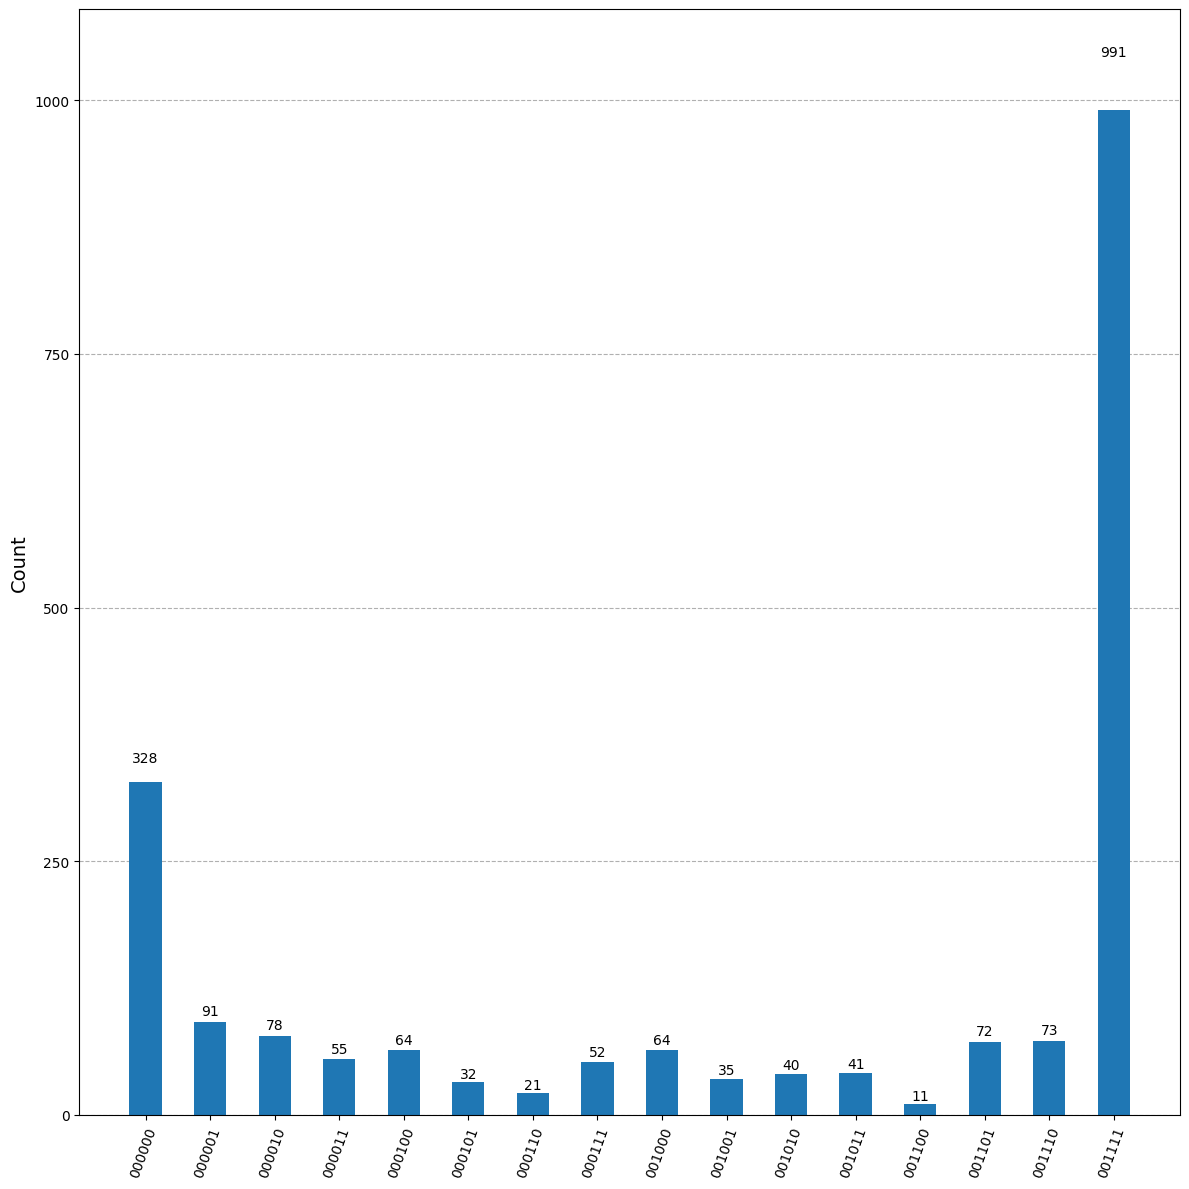

In [15]:
sim = Aer.get_backend('aer_simulator')
trasnpiled_qc = transpile(ansatz.decompose().decompose(), sim)    
result = sim.run(ansatz.decompose().decompose(), shots = 2048).result()
counts = result.get_counts()

plot_histogram(counts, figsize= (12, 12))

In [ ]:
print(counts)
sq = 0
for key, val in counts.items():
    # print(key, val)
    # print(int(key, 2))
    sq += 1 - int(key, 2) * val
print(sq)

{'0001100': 112, '0001001': 118, '0000001': 141, '0001010': 141, '0000101': 130, '0000000': 133, '0000110': 126, '0001011': 130, '0000111': 129, '0000011': 138, '0001111': 123, '0000010': 119, '0000100': 120, '0001000': 120, '0001101': 141, '0001110': 127}
-15228
